# Transform COCO keypoints to more convinent format and save

In [1]:
import json
import os
import objectpath
from itertools import groupby
import numpy as np


In [2]:
import tensorflow as tf

In [6]:
DATASET_PATH=r"./dataset/"
IMAGES_PATH=DATASET_PATH+"/train2017"
ANNOTATIONS_PATH=DATASET_PATH+"/annotations/person_keypoints_train2017.json"

In [7]:
with open(ANNOTATIONS_PATH,'r') as f:
    json_file=json.load(f)
json_tree = objectpath.Tree(json_file)

Extract image_id,keypoints pair

In [9]:
#del json_tree
del json_file

In [10]:
import gc
gc.collect()

7

sort and grouby to group all key points for an image

In [8]:
img_keypts_orig=[[x['image_id'],x['keypoints']] for x in json_tree.execute("$.annotations[@.num_keypoints is not 0]")]

In [11]:
img_keypts_sorted=sorted(img_keypts_orig,key=lambda x: x[0])
img_keypts_grouped=[list(g) for k, g in groupby(img_keypts_sorted,key=lambda x:x[0])]
img_keypts_grouped=[[x[0][0],[y[1] for y in x]] for x in img_keypts_grouped]
img_keypts=[[x[0],np.array(x[1],dtype=np.float32).reshape((-1,17,3))] for x in img_keypts_grouped]

In [12]:
import collections

In [100]:
img_keypts=collections.defaultdict(list)
for x in json_tree.execute("$.annotations[@.num_keypoints is not 0]"):
    img_keypts[x['image_id']].append(np.array(x['keypoints'],dtype=np.float32).reshape((17,3)))
    


In [104]:
img_keypts={k:np.array(img_keypts[k],dtype=np.float32) for k in img_keypts}

In [105]:
(img_keypts[110]).shape

(8, 17, 3)

Experimental

In [49]:
img_keypts[4]

[110, array([[[459.,  91.,   2.],
         [511.,  61.,   2.],
         [449.,  44.,   2.],
         [590.,  57.,   2.],
         [  0.,   0.,   0.],
         [622., 182.,   2.],
         [355., 126.,   2.],
         [  0.,   0.,   0.],
         [235., 205.,   2.],
         [491., 371.,   2.],
         [270., 240.,   2.],
         [531., 461.,   1.],
         [331., 423.,   1.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],
 
        [[ 67., 251.,   2.],
         [ 91., 231.,   2.],
         [ 54., 225.,   2.],
         [160., 239.,   2.],
         [  0.,   0.,   0.],
         [193., 304.,   2.],
         [ 31., 305.,   2.],
         [234., 400.,   1.],
         [ 10., 412.,   1.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],
 
   

In [24]:
from IPython.display import Image, display
def id_to_filename(id):
    return os.path.join(IMAGES_PATH,f"{id:012}.jpg")

def show_by_id(id):
    display(Image(filename=id_to_filename(id)))

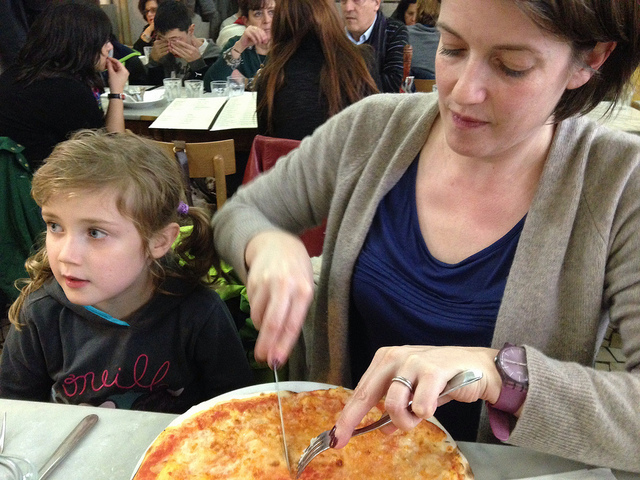

In [25]:
show_by_id(110)

get image sizes, and filter by those in first list

In [89]:
image_sizes={}
for x in json_tree.execute("$.images"):
    image_sizes[x['id']]=(x['width'],x["height"])

In [38]:
image_sizes[9]

(640, 480)

In [178]:
imgs_combined={x:{"size":image_sizes[x],"keypoints":img_keypts[x]} for x in img_keypts}

TESTING

Visualizing

In [62]:
class Gaussian_spots():
    """This creates a tensor of gaussian spots, dimensions are given via img_size and spot_size corresonds to sigma squared"""
    def __init__(self,spot_size,img_size):
        self.x_grid=np.arange(0,img_size[0],1,dtype=np.float32)
        self.y_grid=np.arange(0,img_size[1],1,dtype=np.float32)
        self.xx,self.yy=np.meshgrid(self.x_grid,self.y_grid)
        self.spot_size=spot_size
        
    def __call__(self,spots):
        """spots must be a list of (x,y) tuples"""
        total_dist=None
        for spot in spots:            
            #compute distances matrix to spot
            spot_dist=np.linalg.norm(np.stack((self.xx-spot[0],self.yy-spot[1]),axis=-1),axis=-1) 
            if total_dist is None:
                total_dist=spot_dist
            #an optimization. minimum of the distances instead of maximum of the gaussians as in the paper
            total_dist=np.minimum(spot_dist,total_dist)
            

        return np.exp((-(total_dist**2)/self.spot_size),dtype=np.float32)

In [71]:
gaussian_spots=Gaussian_spots(80,(640, 480))

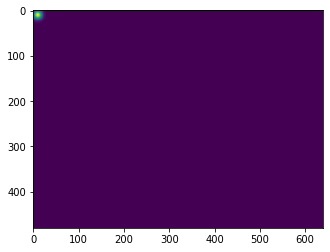

In [72]:
plt.imshow(gaussian_spots([(10,10)]))

In [29]:
def get_mat_by_id(id):
    f=tf.io.read_file(id_to_filename(id))
    img=tf.image.decode_jpeg(f)
    img=tf.image.convert_image_dtype(img,tf.float32)
    return img.numpy()
    #display(Image(filename=))

In [32]:
import matplotlib.pyplot as plt

In [115]:
def draw_image_with_spots(img,spots):
    plt.axis('off')    
    spot=np.expand_dims(gaussian_spots(spots),-1)
    spot=np.insert(spot, 1,0, axis=2)
    spot=np.insert(spot, 1,0, axis=2)
    plt.imshow(np.maximum(img,spot))

In [121]:
it=iter(img_keypts)

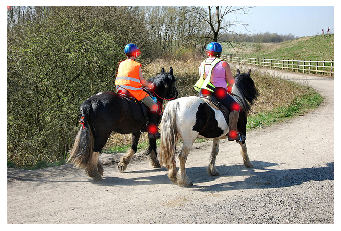

In [134]:
myid=next(it)
img=get_mat_by_id(myid)

spots=img_keypts[myid][:,:,0:2].reshape((-1,2))

gaussian_spots=Gaussian_spots(80,image_sizes[myid])

#spots.shape
draw_image_with_spots(img,spots)

In [132]:
np.expand_dims(gaussian_spots([(10,10)]),-1).dtype

dtype('float32')

[377999, array([[[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [517., 333.,   2.],
         [  0.,   0.,   0.],
         [521., 341.,   2.],
         [526., 341.,   2.],
         [513., 352.,   2.],
         [  0.,   0.,   0.],
         [504., 359.,   2.],
         [  0.,   0.,   0.],
         [525., 363.,   2.],
         [528., 362.,   2.],
         [507., 369.,   2.],
         [512., 368.,   2.],
         [515., 385.,   2.],
         [512., 386.,   2.]]], dtype=float32)]

In [99]:
img_keypts[11]

[275219, array([[[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [438., 183.,   2.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]]], dtype=float32)]

In [136]:
img_keypts[110]

array([[[459.,  91.,   2.],
        [511.,  61.,   2.],
        [449.,  44.,   2.],
        [590.,  57.,   2.],
        [  0.,   0.,   0.],
        [622., 182.,   2.],
        [355., 126.,   2.],
        [  0.,   0.,   0.],
        [235., 205.,   2.],
        [491., 371.,   2.],
        [270., 240.,   2.],
        [531., 461.,   1.],
        [331., 423.,   1.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[ 67., 251.,   2.],
        [ 91., 231.,   2.],
        [ 54., 225.,   2.],
        [160., 239.,   2.],
        [  0.,   0.,   0.],
        [193., 304.,   2.],
        [ 31., 305.,   2.],
        [234., 400.,   1.],
        [ 10., 412.,   1.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,  

In [151]:
coco_keypoints=next(json_tree.execute("$.categories[@.id is 1].keypoints"))
coco_keypoints
coco_joints=next(json_tree.execute("$.categories[@.id is 1].skeleton"))
coco_joints=np.array(coco_joints,dtype=np.uint8)
coco_joints=coco_joints-1 #shift to match keypoint numberings
print(f"These are the COCO keypoints {coco_keypoints}")
print(f"These are the joint pairs {coco_joints}")

These are the COCO keypoints ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']
These are the joint pairs [[15 13]
 [13 11]
 [16 14]
 [14 12]
 [11 12]
 [ 5 11]
 [ 6 12]
 [ 5  6]
 [ 5  7]
 [ 6  8]
 [ 7  9]
 [ 8 10]
 [ 1  2]
 [ 0  1]
 [ 0  2]
 [ 1  3]
 [ 2  4]
 [ 3  5]
 [ 4  6]]


In [180]:
def create_joints(keypts):
    joints=[]
    for kp1_idx,kp2_idx in coco_joints:
        kp1=keypts[kp1_idx]
        kp2=keypts[kp2_idx]       
        if kp1[2]==0 or kp2[2]==0:
            new_joint=(0,0,0,0,0)
            joints.append(new_joint)
            continue
        new_joint=(*kp1[0:2],*kp2[0:2],min(kp1[2],kp2[2]))
        joints.append(new_joint)
    
    return np.array(joints,dtype=np.float32)
def create_all_joints(all_keypts):
    all_joints=[]
    for keypts in all_keypts:
        all_joints.append(create_joints(keypts))
    return np.array(all_joints,dtype=np.float32) 

In [182]:
create_all_joints(img_keypts[110]).shape

(8, 19, 5)

In [183]:
for idd in imgs_combined:
    imgs_combined[idd]["joints"]=create_all_joints( imgs_combined[idd]["keypoints"])

In [189]:
imgs_combined[110]["joints"]

array([[[  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [531., 461., 331., 423.,   1.],
        [622., 182., 531., 461.,   1.],
        [355., 126., 331., 423.,   1.],
        [622., 182., 355., 126.,   2.],
        [  0.,   0.,   0.,   0.,   0.],
        [355., 126., 235., 205.,   2.],
        [  0.,   0.,   0.,   0.,   0.],
        [235., 205., 270., 240.,   2.],
        [511.,  61., 449.,  44.,   2.],
        [459.,  91., 511.,  61.,   2.],
        [459.,  91., 449.,  44.,   2.],
        [511.,  61., 590.,  57.,   2.],
        [  0.,   0.,   0.,   0.,   0.],
        [590.,  57., 622., 182.,   2.],
        [  0.,   0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]

In [212]:
s=imgs_combined[110]["joints"].shape
n=imgs_combined[110]["joints"].transpose((1,0,2))
n[0]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [207]:
o=imgs_combined[110]["joints"]
o[:,4]

array([[531., 461., 331., 423.,   1.],
       [  0.,   0.,   0.,   0.,   0.],
       [297., 192., 353., 190.,   1.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [406.,  99., 436., 100.,   1.],
       [384., 132., 340., 136.,   1.]], dtype=float32)